Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Instantiating the full dataset...
Loading data from /kaggle/input/nlp-cs-2024-25/train_submission.csv ...
Number of labels: 389
Total dataset size: 38754, Training size: 34878, Validation size: 3876
Loading model...


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at papluca/xlm-roberta-base-language-detection and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([389]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([20, 768]) in the checkpoint and torch.Size([389, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA-modified model loaded.


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


Epoch [1/16], Step [100/545], Loss: 4.6175
Epoch [1/16], Step [200/545], Loss: 3.1330
Epoch [1/16], Step [300/545], Loss: 2.4649
Epoch [1/16], Step [400/545], Loss: 2.0144
Epoch [1/16], Step [500/545], Loss: 1.7544
Epoch [1/16] Validation Loss: 1.4283 | Accuracy: 0.6104
Best model updated.
Epoch [2/16], Step [55/545], Loss: 0.7872
Epoch [2/16], Step [155/545], Loss: 1.3379
Epoch [2/16], Step [255/545], Loss: 1.2806
Epoch [2/16], Step [355/545], Loss: 1.1713
Epoch [2/16], Step [455/545], Loss: 1.1313
Epoch [2/16] Validation Loss: 0.9497 | Accuracy: 0.7296
Best model updated.
Epoch [3/16], Step [10/545], Loss: 0.0972
Epoch [3/16], Step [110/545], Loss: 0.9635
Epoch [3/16], Step [210/545], Loss: 0.9063
Epoch [3/16], Step [310/545], Loss: 0.8908
Epoch [3/16], Step [410/545], Loss: 0.8844
Epoch [3/16], Step [510/545], Loss: 0.8531
Epoch [3/16] Validation Loss: 0.8139 | Accuracy: 0.7639
Best model updated.
Epoch [4/16], Step [65/545], Loss: 0.5019
Epoch [4/16], Step [165/545], Loss: 0.7816
E

<ipython-input-1-0766eba28638>:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v).to(device) for k, v in batch.items()}



Validation Accuracy: 0.8215
Validation Precision (macro): 0.8335
Validation Recall (macro):    0.8208
Validation F1 Score (macro):    0.8132

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.92      0.96        13
           2       1.00      1.00      1.00        14
           3       0.33      0.29      0.31         7
           4       0.91      1.00      0.95        10
           6       0.33      0.22      0.27         9
           7       0.83      0.71      0.77         7
           8       0.89      1.00      0.94         8
           9       0.55      0.43      0.48        14
          10       0.41      0.78      0.54         9
          11       0.93      1.00      0.96        13
          12       0.76      0.87      0.81        15
          13       1.00      0.92      0.96        12
          14       1.00      0.78      0.88         9
          15       1.0

<ipython-input-1-0766eba28638>:274: RuntimeWarning: divide by zero encountered in divide
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, None]
<ipython-input-1-0766eba28638>:274: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, None]
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


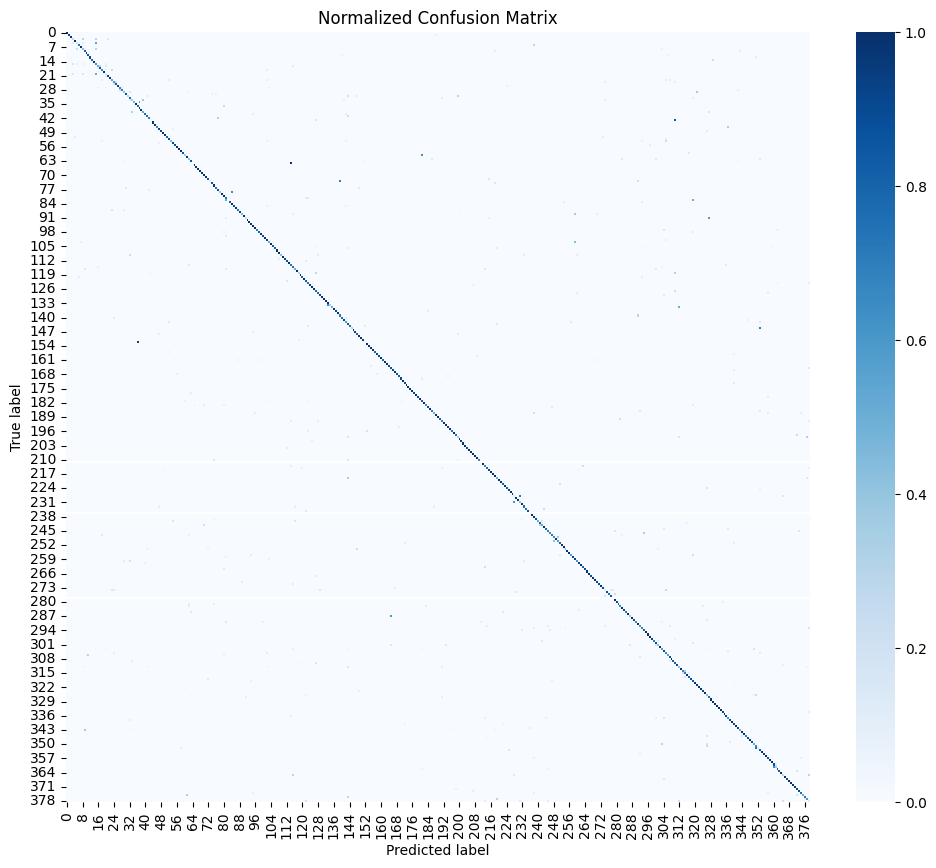

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)

# Import the PEFT (Parameter-Efficient Fine-Tuning) components for LoRA.
from peft import LoraConfig, TaskType, get_peft_model
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

# -------------------------------
# 1. Dataset Definition
# -------------------------------
class TextDataset(Dataset):
    def __init__(self, csv_path, tokenizer, max_length, augment=False):
        """
        Args:
            csv_path (str): Path to the CSV file. The CSV should have columns 'Text' and 'Label'.
            tokenizer: A Huggingface tokenizer (e.g., RobertaTokenizerFast).
            max_length (int): Maximum tokenized sequence length.
            augment (bool): Whether to apply data augmentation.
        """
        print(f"Loading data from {csv_path} ...")
        self.data = pd.read_csv(csv_path)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.augment = augment

        # Remove rows with missing labels and create a deterministic label mapping.
        self.data = self.data[self.data["Label"].notnull()]
        unique_labels = sorted(self.data["Label"].unique())
        self.label2idx = {label: idx for idx, label in enumerate(unique_labels)}
        self.idx2label = {idx: label for label, idx in self.label2idx.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row["Text"]
        label = row["Label"]

        # Tokenize text without automatic truncation.
        token_ids = self.tokenizer.encode(text, add_special_tokens=True, truncation=False)

        # Data augmentation: take a random contiguous slice if augmentation is enabled.
        if self.augment and len(token_ids) > self.max_length:
            start_idx = random.randint(0, len(token_ids) - self.max_length)
            token_ids = token_ids[start_idx : start_idx + self.max_length]
        else:
            token_ids = token_ids[: self.max_length]

        # Create an attention mask (1 for each token).
        attention_mask = [1] * len(token_ids)

        label_idx = self.label2idx[label]
        return {
            "input_ids": token_ids,
            "attention_mask": attention_mask,
            "labels": label_idx,
        }


# -------------------------------
# 2. Utility Function to Plot Confusion Matrix
# -------------------------------
def plot_confusion_matrix(cm, title="Confusion matrix", cmap=plt.cm.Blues):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt="d", cmap=cmap)
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


# -------------------------------
# 3. Main Training and Evaluation Loop
# -------------------------------
def main():
    # ----- Settings and Hyperparameters -----
    model_name = "papluca/xlm-roberta-base-language-detection"
    # model_name = "FacebookAI/xlm-roberta-large"
    # model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
    csv_path = "/kaggle/input/nlp-cs-2024-25/train_submission.csv"
    max_length = 128
    augment = False  # set to True to enable data augmentation for training data

    # Training hyperparameters
    num_train_epochs = 10
    learning_rate = 5e-4
    weight_decay = 0.01
    per_device_train_batch_size = 64
    per_device_eval_batch_size = 64
    logging_steps = 100

    # ----- Load Tokenizer and Prepare Dataset -----
    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    print("Instantiating the full dataset...")
    full_dataset = TextDataset(csv_path, tokenizer, max_length, augment=augment)
    num_labels = len(full_dataset.label2idx)
    print(f"Number of labels: {num_labels}")

    # Split into training (90%) and validation (10%) sets.
    dataset_size = len(full_dataset)
    train_size = int(0.9 * dataset_size)
    val_size = dataset_size - train_size
    print(
        f"Total dataset size: {dataset_size}, Training size: {train_size}, Validation size: {val_size}"
    )
    train_dataset, val_dataset = random_split(
        full_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42),
    )

    # Create DataLoaders.
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=per_device_train_batch_size,
        shuffle=True,
        collate_fn=data_collator,
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=per_device_eval_batch_size,
        shuffle=False,
        collate_fn=data_collator,
    )

    # ----- Load the Model and Wrap with LoRA (PEFT) -----
    print("Loading model...")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels, ignore_mismatched_sizes=True
    )

    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,  # Sequence classification task
        inference_mode=False,
        r=8,           # Rank of the LoRA update matrices (hyperparameter)
        lora_alpha=32, # Scaling factor
        lora_dropout=0.1,  # Dropout probability applied to LoRA layers
        target_modules=["query", "value"],  # Target modules to apply LoRA on
    )
    model = get_peft_model(model, lora_config)
    print("LoRA-modified model loaded.")

    # ----- Prepare for Training -----
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Create optimizer. Here we use AdamW with weight decay.
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Optionally: set up a learning rate scheduler (skipped here for simplicity)
    best_val_accuracy = 0.0
    global_step = 0

    # ----- Training Loop -----
    for epoch in range(num_train_epochs):
        model.train()
        running_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            # Move batch tensors to the device.
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            global_step += 1

            if global_step % logging_steps == 0:
                avg_loss = running_loss / logging_steps
                print(f"Epoch [{epoch+1}/{num_train_epochs}], Step [{step+1}/{len(train_dataloader)}], Loss: {avg_loss:.4f}")
                running_loss = 0.0

        # ----- Validation at the End of Each Epoch -----
        model.eval()
        all_preds = []
        all_labels = []
        eval_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            for batch in val_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                eval_loss += outputs.loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch["labels"].cpu().numpy())
                num_batches += 1

        avg_eval_loss = eval_loss / num_batches
        val_accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch [{epoch+1}/{num_train_epochs}] Validation Loss: {avg_eval_loss:.4f} | Accuracy: {val_accuracy:.4f}")

        # Save best model (if desired)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict()
            print("Best model updated.")

    # (Optionally, reload the best model state)
    model.load_state_dict(best_model_state)

    # ----- Save the Model and Tokenizer -----
    output_dir = "./lora_roberta_finetuned"
    os.makedirs(output_dir, exist_ok=True)
    print("Saving model and tokenizer...")
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model saved to {output_dir}")

    # ----- Final Evaluation on the Validation Set -----
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: torch.tensor(v).to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    # Compute overall accuracy.
    acc = accuracy_score(all_labels, all_preds)
    print(f"\nValidation Accuracy: {acc:.4f}")

    # Compute precision, recall, and F1 score (macro averaged)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro", zero_division=0
    )
    print(f"Validation Precision (macro): {precision:.4f}")
    print(f"Validation Recall (macro):    {recall:.4f}")
    print(f"Validation F1 Score (macro):    {f1:.4f}")

    # Generate the full classification report as a dictionary.
    report_dict = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    # Print the report to console.
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, zero_division=0))
    
    # Convert the classification report into a DataFrame and save it as CSV.
    report_df = pd.DataFrame(report_dict).transpose()
    report_csv_path = os.path.join(output_dir, "classification_report.csv")
    report_df.to_csv(report_csv_path, index=True)
    print(f"Classification report saved to {report_csv_path}")

    # Compute and plot the confusion matrix.
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix shape:", cm.shape)

    # Plot a normalized confusion matrix.
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, None]
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, cmap="Blues", cbar=True)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
    plt.show()


if __name__ == "__main__":
    main()